# Notebook 3c: User Churn

In this notebook I will be exploring user churn from reddit. This may not be really strongly correlated to user churn of the game itself, but it may show some trends in how people interact with each other and with the game online. 

Churn is when a customer, player, user, etc decides to discontinue his or her relationship with the company, game, forum, etc. In this notebook, I will create a target column that says whether or not a certain person has 'churned' in order to calculate the likelihood of someone churning given their overall sentiment, the number of times they've commented, and other meta data. I came up with my own filter for when someone churns, since that data is not readily available. 

Churn is important for businesses in general, but for this, I am examining churn as a result of patches being unsatisfactory, as the two most certainly have some correlation. 

In [321]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
%matplotlib inline

In [322]:
df_users = pd.read_csv('../data/df_users.csv', index_col = 'author')

In [323]:
df_users['duration'] = df_users['duration'].apply(lambda x : x[:3])

In [324]:
df_daily = pd.read_csv('../data/df_daily.csv', index_col = 'date')

In [369]:
df_daily.index = pd.to_datetime(df_daily.index)

In [325]:
df_daily.tail()

,created_utc,score,compound,character_count,word_count,interaction_score_compound,count_comments,patch_update,op,nerf,...,auto,noob,range,rate,fire,compound_sum,unique_authors,interaction_sum,comment_count,body
date,,,,,,,,,,,,,,,,,,,,,
2019-04-27,2770336896291,5031,0.076103,282671.0,53563,0.141100,1780,0.0,167.0,41.0,...,12.0,5.0,46.0,55.0,31.0,135.4626,903,251.1578,1780,too bad there s no in game leaderboards to sho...
2019-04-28,2084098985285,4100,0.113243,218085.0,41270,0.534931,1339,0.0,103.0,9.0,...,4.0,8.0,25.0,37.0,23.0,151.6327,644,716.2728,1339,yes let s make the game free to play too whil...
2019-04-29,3780866670544,10264,0.132022,370348.0,69910,1.129545,2429,0.0,220.0,4.0,...,11.0,7.0,46.0,89.0,32.0,320.6813,1019,2743.6640,2429,in iw they were just a small cosmetic item ad...
2019-04-30,6453829629874,19492,0.064943,626022.0,117751,-0.351741,4146,1.0,433.0,39.0,...,16.0,19.0,81.0,156.0,64.0,269.2556,1763,-1458.3172,4146,i m not even joking when i say this i ve quit...
2019-05-01,7445776214860,4783,0.073185,929949.0,173838,0.073185,4783,0.0,548.0,48.0,...,9.0,10.0,73.0,228.0,75.0,350.0440,2004,350.0440,4783,so they re just gonna ignore the sparrow bug y...


In [326]:
import re

Using my regex function to remove all non number characters from the duration column so that I can turn it into an integer. 

In [327]:
def regex_func(x):
    variable = (re.sub(r"([a-zA-Z ])", 
                       "", 
                       x))
    return variable

In [328]:
df_users['duration'] = df_users['duration'].apply(regex_func)

In [329]:
df_users['duration'] = df_users.duration.values.astype('int64')

In [330]:
df_users.head()

,count_comments,compound_mean,compound_sum,mean_score,sum_score,mean_interaction,start_date,end_date,duration,mean_word_count,mean_char_count
author,,,,,,,,,,,
-------_---,2,0.038450,0.0769,1.000000,2,0.038450,2019-01-06,2019-01-17,11,8.000000,39.000000
----_,3,0.549133,1.6474,67.333333,202,31.727433,2018-10-22,2018-10-22,0,14.333333,68.000000
---Alexander---,107,0.152577,16.3257,1.121495,120,0.172803,2018-12-16,2019-04-23,128,19.878505,108.121495
---KC---,1,-0.401900,-0.4019,1.000000,1,-0.401900,2019-03-15,2019-03-15,0,25.000000,122.000000
---Kaiser,5,0.021400,0.1070,1.000000,5,0.021400,2018-11-02,2018-11-05,3,97.000000,504.800000


In [331]:
df_users.shape

(128691, 11)

In [332]:
df_users[(df_users['end_date'] < '2019-03-15') | (df_users['duration'] < 20)].shape

(116532, 11)

In [333]:
df_daily['unique_authors'].max() - df_daily['unique_authors'].min()

8810

In [334]:
df_daily['unique_authors'].max()

9429

In [335]:
df_daily['unique_authors'].min()

619

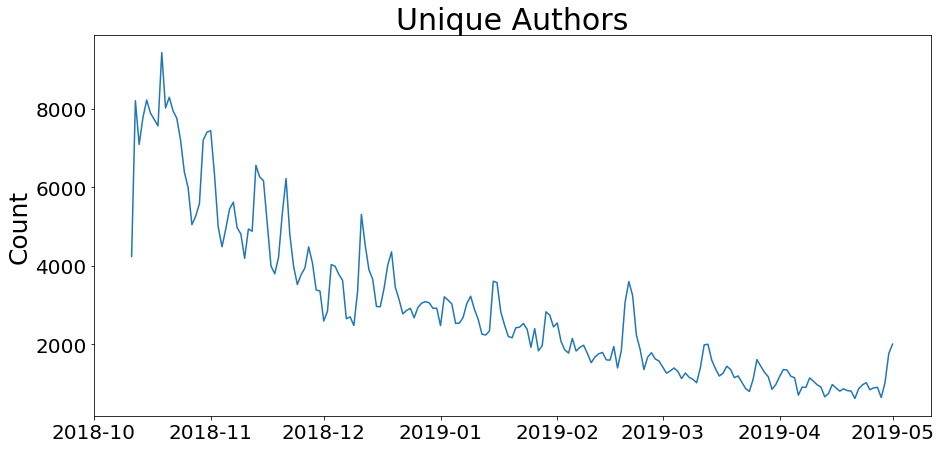

In [370]:
plt.figure(figsize = (15,7))
plt.title('Unique Authors', fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Count', fontsize = 25)
plt.plot(df_daily['unique_authors'])

Just wanted to examine the loss in user participation to get a feel for how many users churned. This looks like about 80-90% of users churned in the last six months. 

Creating a column called churn with a mask that says whether or not that customer churned. For my conditinal, I picked 30 days from when my data was pulled AND less than 5 days active on the subreddit. 

In [337]:
df_users['churn'] = np.where((df_users['end_date'] < '2019-03-15') | (df_users['duration'] < 5), 1, 0)

After creating my churn column, I am examining my class distributions. As we can see below, my classes are pretty unbalanced. With a distribution of 90% to the target class (churn) and 10% to the zero class.

In [338]:
df_users.churn.value_counts(normalize = True)

1    0.900382
0    0.099618
Name: churn, dtype: float64

My distribution for churned users matches that of how many people churned based on the number of unique commenters on a daily basis showed in the graph above. 

In [339]:
df_users.head()

,count_comments,compound_mean,compound_sum,mean_score,sum_score,mean_interaction,start_date,end_date,duration,mean_word_count,mean_char_count,churn
author,,,,,,,,,,,,
-------_---,2,0.038450,0.0769,1.000000,2,0.038450,2019-01-06,2019-01-17,11,8.000000,39.000000,1
----_,3,0.549133,1.6474,67.333333,202,31.727433,2018-10-22,2018-10-22,0,14.333333,68.000000,1
---Alexander---,107,0.152577,16.3257,1.121495,120,0.172803,2018-12-16,2019-04-23,128,19.878505,108.121495,0
---KC---,1,-0.401900,-0.4019,1.000000,1,-0.401900,2019-03-15,2019-03-15,0,25.000000,122.000000,1
---Kaiser,5,0.021400,0.1070,1.000000,5,0.021400,2018-11-02,2018-11-05,3,97.000000,504.800000,1


Creating my X and y, dropping churn, start date, and end date. 

In [340]:
X = df_users.drop(['churn', 'start_date', 'end_date'], axis = 1)
y = df_users['churn']

Instantiating my XGBoost classifier and fitting it. 

The following example was inspired by [this post](https://www.datascience.com/blog/churn-prediction-python)

In [341]:
xgb = XGBClassifier()
xgb.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Using XGBoost plot called 'plot_tree' to plot my churn tree. 

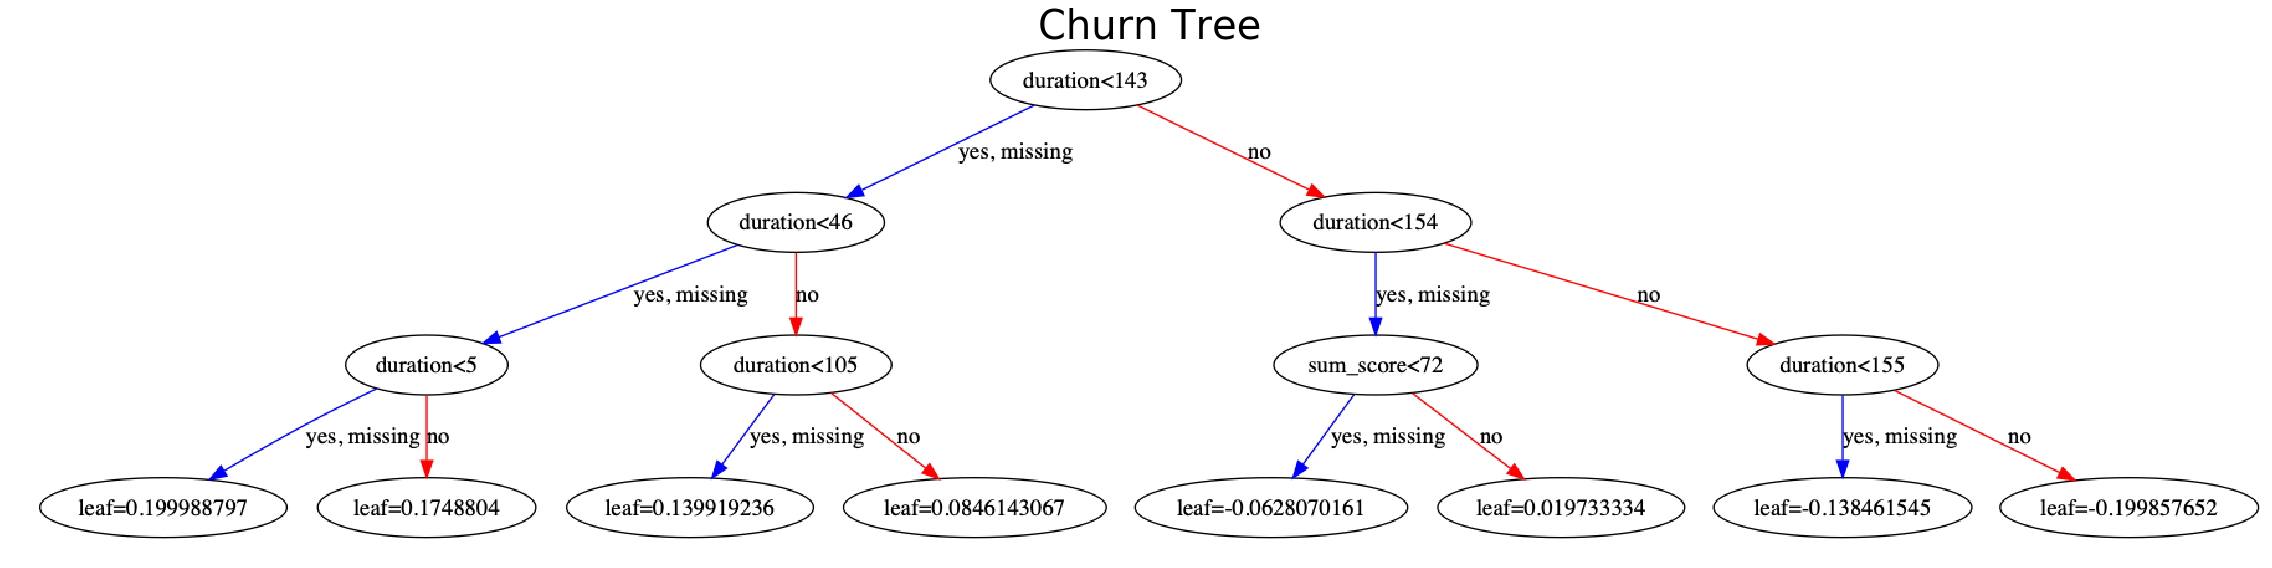

<Figure size 432x288 with 0 Axes>

In [342]:
# plot single tree
fig, ax = plt.subplots(figsize = (40,30))
plot_tree(xgb, ax=ax)
plt.title('Churn Tree', fontsize = 40)
plt.show()
plt.savefig('../plots/xgb_churn_tree')

Essentially, this graph takes certain features, in this case the number of comments as the biggest indicator of whether or not someone has churned, and sets a condition at each step. From there, it goes down to the next split and looks at another condition, and so on. 

In [343]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 13,
                                                    stratify = y)

In [344]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [345]:
preds = xgb.predict(X_test)

In [346]:
accuracy_score(y_test, preds)

0.9474404003356852

Despite my classes being unbalanced, my xgboost model can still predict with 95% accuracy who will churn and who will not. It takes into account their duration, and from there asks different questions about their reddit score.

Setting up a confusion matrix.

In [347]:
cm = confusion_matrix(y_test, preds)

In [348]:
cm_df = pd.DataFrame(cm, columns = ['pred_neg', 'pred_pos'], index = ['actual_neg', 'actual_pos'])

In [349]:
cm_df

,pred_neg,pred_pos
actual_neg,1631,1574
actual_pos,117,28851


Instantiating my CoxPHFitter. This will help determine how long each user is likely to stay engaged based on the rest of the features associated with them. 

In [350]:
cph = CoxPHFitter()

Removing the start and end date from my df for X.

In [351]:
X = df_users.drop(['start_date', 'end_date'], axis = 1)

Fitting my cox PH fitter, and setting my duration column as duration, and my churn column as my event column. From here it will calculate the likelihood of someone remaining for certain amounts of time. 

In [352]:
cph.fit(X, duration_col = 'duration', event_col = 'churn', show_progress = True)

Iteration 1: norm_delta = 0.30850, step_size = 0.9500, ll = -1272374.90450, newton_decrement = 2639.50628, seconds_since_start = 0.1
Iteration 2: norm_delta = 0.31782, step_size = 0.9500, ll = -1269670.94168, newton_decrement = 4584.12866, seconds_since_start = 0.2
Iteration 3: norm_delta = 0.56407, step_size = 0.9500, ll = -1263628.74172, newton_decrement = 3644.15464, seconds_since_start = 0.3
Iteration 4: norm_delta = 0.60904, step_size = 0.9310, ll = -1259054.53597, newton_decrement = 1566.60878, seconds_since_start = 0.4
Iteration 5: norm_delta = 0.33160, step_size = 0.9124, ll = -1257247.30372, newton_decrement = 266.58631, seconds_since_start = 0.6
Iteration 6: norm_delta = 0.08243, step_size = 0.8941, ll = -1256962.96477, newton_decrement = 19.05151, seconds_since_start = 0.7
Iteration 7: norm_delta = 0.02076, step_size = 1.0000, ll = -1256942.66595, newton_decrement = 2.25266, seconds_since_start = 0.7
Iteration 8: norm_delta = 0.00624, step_size = 1.0000, ll = -1256940.10528,

<lifelines.CoxPHFitter: fitted with 128691 observations, 12820 censored>

Before getting into different coefficients, I will explain Hazard. Hazard is essentially, the rate at which something dies, a user stops using, etc. The hazard function estimates the likelihood of survival to a certain point in time based on its survival at the previous point in time. 

In [353]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 128691 observations, 12820 censored>
      duration col = 'duration'
         event col = 'churn'
number of subjects = 128691
  number of events = 115871
    log-likelihood = -1256939.94
  time fit was run = 2019-05-17 19:29:32 UTC

---
                  coef exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
count_comments   -0.04      0.96      0.00 -95.50 <0.005       inf       -0.04       -0.04
compound_mean     0.09      1.09      0.01   8.18 <0.005     51.61        0.07        0.11
compound_sum     -0.03      0.97      0.00 -15.74 <0.005    183.10       -0.03       -0.03
mean_score       -0.00      1.00      0.00  -2.10   0.04      4.82       -0.00       -0.00
sum_score        -0.00      1.00      0.00  -0.04   0.97      0.04       -0.00        0.00
mean_interaction  0.00      1.00      0.00   2.29   0.02      5.49        0.00        0.00
mean_word_count  -0.00      1.00      0.00  -3.07 <0.005      8.88       -0.00       -0.00

In [354]:
cph.hazards_

count_comments     -0.037441
compound_mean       0.086709
compound_sum       -0.029744
mean_score         -0.000964
sum_score          -0.000003
mean_interaction    0.001520
mean_word_count    -0.001123
mean_char_count     0.000355
dtype: float64

These are the coefficients in the hazard function for each user. So, a one unit change in each of these will result in an exp(x) increase in the baseline hazards (below). The baseline hazards are the hazards of each user. The combination of these two things will determine when a user drops off, ie when they are no longer satisfied with the game. 

In [355]:
cph.baseline_hazard_[:10]

,baseline hazard
T,
0.0,0.387918
1.0,0.056085
2.0,0.028274
3.0,0.023609
4.0,0.022503
5.0,0.019216
6.0,0.018922
7.0,0.020696
8.0,0.019109


In [356]:
cph._log_likelihood

-1256939.9412380967

In [357]:
cph.variance_matrix_

array([[ 1.53692946e-07,  6.88548637e-07, -1.88491406e-07,
         4.42638130e-08, -1.12802263e-08, -1.29698705e-08,
        -2.73791036e-09,  2.08832206e-10],
       [ 6.88548637e-07,  1.12452496e-04, -1.15267964e-05,
         1.63166599e-07, -9.20005244e-09, -9.09975458e-07,
         3.88500546e-08, -6.59228969e-09],
       [-1.88491406e-07, -1.15267964e-05,  3.56945272e-06,
         4.32672483e-09, -2.69967689e-10, -3.63356469e-09,
        -4.89031068e-09,  1.24998755e-09],
       [ 4.42638130e-08,  1.63166599e-07,  4.32672483e-09,
         2.10024140e-07, -2.03130456e-08, -9.34740968e-08,
         6.12553176e-10, -3.76783886e-11],
       [-1.12802263e-08, -9.20005244e-09, -2.69967689e-10,
        -2.03130456e-08,  5.09140606e-09,  6.16070820e-09,
         5.48078149e-11, -8.83870403e-12],
       [-1.29698705e-08, -9.09975458e-07, -3.63356469e-09,
        -9.34740968e-08,  6.16070820e-09,  4.42276220e-07,
        -1.28625549e-10,  2.42130454e-11],
       [-2.73791036e-09,  3.885005

Above, we can see the variance matrix of each coefficient, as well as the value of  maximum log likelihood.

Below, we can see each user's probability of surviving a certain length of time based on the different features in the dataset. 

In [358]:
cph.predict_survival_function(X, times = [5., 25., 50., 75, 150])

,-------_---,----_,---Alexander---,---KC---,---Kaiser,---__-_----___-_,--Aux--,--ChrisPBacon,--Clintoris--,--CrusaderFTW,...,zzurxx,zzzHooligan,zzzMARZBARzzz,zzz_sleep_zzz,zzzanimal,zzzorn,zzzornbringer,zzzryanzzz,zzzyx3,zzzz271
5.0,0.469152,0.487840,0.990694,0.460899,0.486608,0.998236,0.465449,0.432542,0.494417,0.536050,...,0.549418,0.568216,0.450030,0.583958,0.734095,0.671064,0.451981,0.778609,0.465088,0.480259
25.0,0.301705,0.320953,0.985305,0.293345,0.319671,0.997208,0.297943,0.265287,0.327831,0.372602,...,0.387420,0.408616,0.282467,0.426684,0.612974,0.531755,0.284409,0.672857,0.297578,0.313092
50.0,0.187470,0.204388,0.979531,0.180252,0.203248,0.996102,0.184212,0.156631,0.210533,0.251762,...,0.265860,0.286400,0.170983,0.304246,0.504705,0.413804,0.172627,0.574901,0.183896,0.197428
75.0,0.118548,0.132340,0.974000,0.112766,0.131401,0.995038,0.115930,0.094292,0.137429,0.172588,...,0.184991,0.203385,0.105432,0.219663,0.418547,0.325006,0.106725,0.494062,0.115678,0.126627
150.0,0.019353,0.023724,0.952434,0.017643,0.023413,0.990840,0.018570,0.012672,0.025439,0.038772,...,0.044083,0.052533,0.015580,0.060574,0.199640,0.125034,0.015935,0.271340,0.018495,0.021864


In [359]:
user_survival = cph.predict_survival_function(X)

Below is the accuracy score of the cox ph fitter model. 

In [360]:
cph.score_

0.8561631729260637

In [361]:
cph.predict_median(X)

,0.5
-------_---,3.0
----_,5.0
---Alexander---,inf
---KC---,3.0
---Kaiser,4.0
---__-_----___-_,inf
--Aux--,3.0
--ChrisPBacon,2.0
--Clintoris--,5.0
--CrusaderFTW,9.0


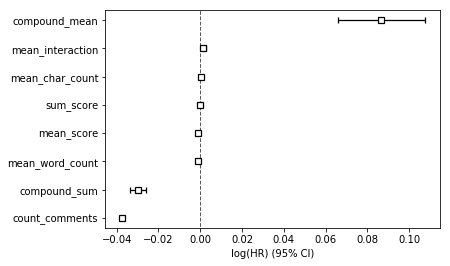

In [362]:
cph.plot()

The above graph is just another way to show the hazard coefficients that we talked about above. 

In [363]:
from lifelines import KaplanMeierFitter

In [364]:
kmf = KaplanMeierFitter()
kmf.fit(df_users['duration'], df_users['churn'], label = 'Kaplan Meier Estimator')

<lifelines.KaplanMeierFitter: fitted with 128691 observations, 12820 censored>

Text(0.5, 1.0, 'Kaplan Meier Churn')

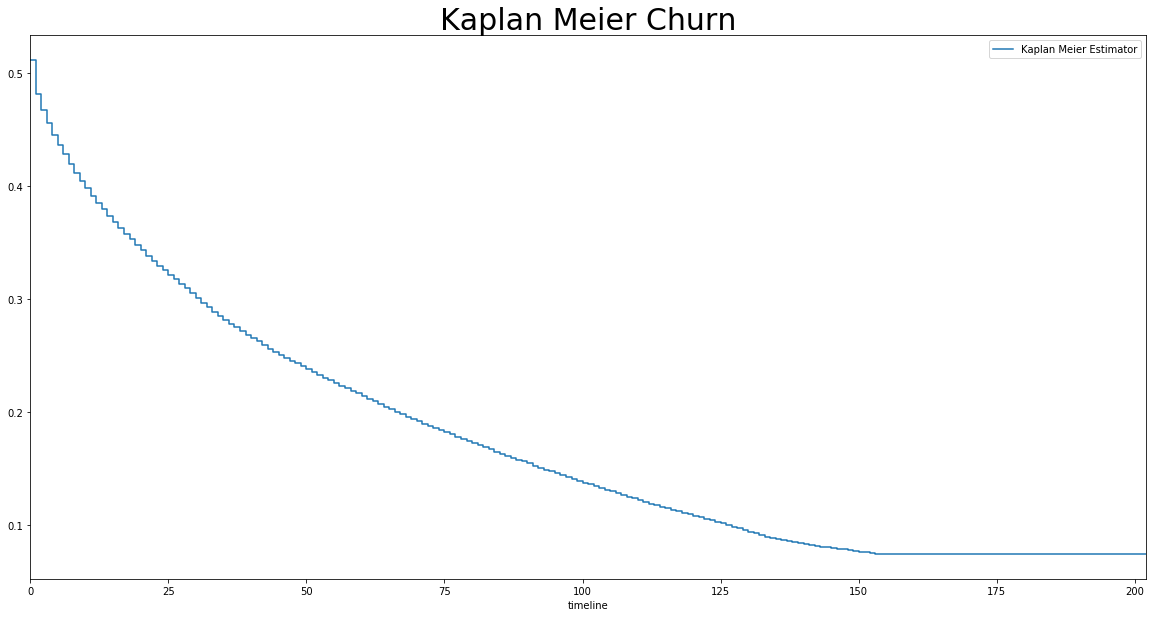

In [365]:
fix, ax = plt.subplots(figsize = (20,10))
kmf.plot(ci_show = False, ax = ax)
plt.title('Kaplan Meier Churn', fontsize = 30)

The above graph shows the churn rate as the timeline continues. As we get further into the timeline, the churn rate decreases, as those are the users that are likely to stay longer, the devoted participants, if you will.

In [366]:
df_users['compound_mean']

author
-------_---             0.038450
----_                   0.549133
---Alexander---         0.152577
---KC---               -0.401900
---Kaiser               0.021400
---__-_----___-_        0.000535
--Aux--                -0.144200
--ChrisPBacon           0.733100
--Clintoris--          -0.031325
--CrusaderFTW          -0.445773
--Dawn--                0.027267
--DeusVult--           -0.127429
--DreadPirateRoberts   -0.050591
--Equinox--             0.321350
--Happy--               0.064483
--Kenshiro--            0.107458
--LilNut--              0.002431
--M0ses--              -0.230950
--ME-Vgmol2-           -0.138271
--PickleRick            0.492600
--Rave--                0.278833
--Raz--                -0.440400
--SicParvisMagnA--     -0.307225
--UnBanable--           0.648600
--Winchester--         -0.259200
--XxNoobSlayer69xX--   -0.542300
--__________--         -0.334700
--cooper--             -0.157344
--jdmasf_ck--           0.041522
--llll-----llll--       0.131415
   

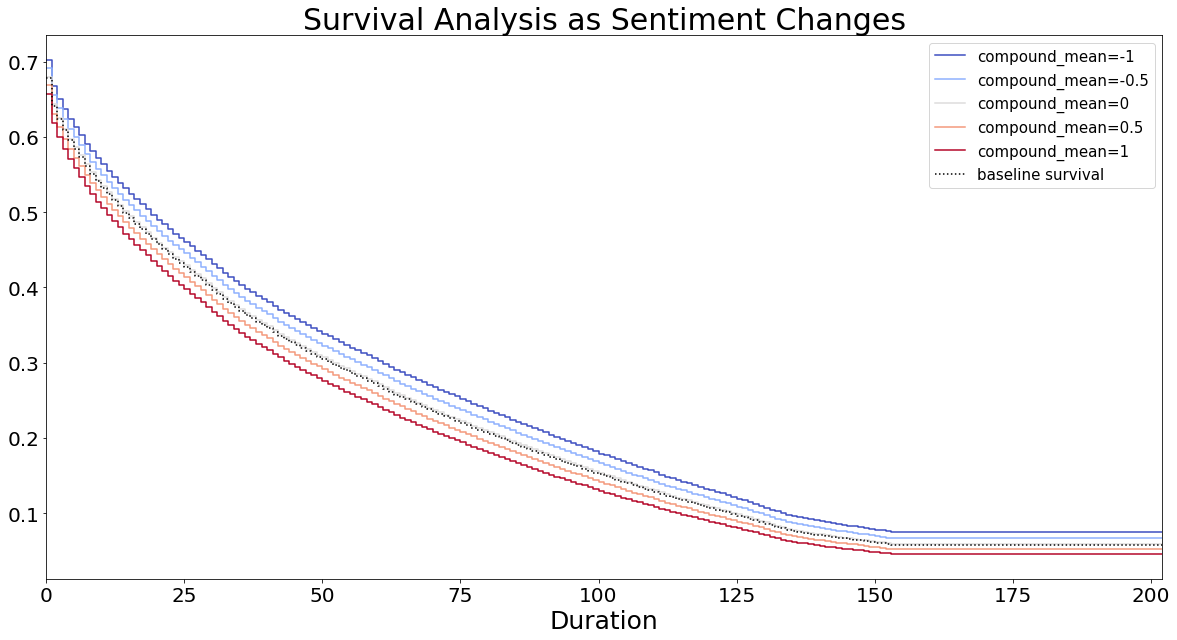

In [367]:
fig, ax = plt.subplots(figsize = (20,10))
cph.plot_covariate_groups('compound_mean', [-1, -.5, 0, .5, 1], cmap='coolwarm', ax = ax)
plt.xlabel('Duration', fontsize = 25)
plt.xticks(fontsize = 20)
plt.title('Survival Analysis as Sentiment Changes', fontsize = 30)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15);
plt.savefig('../plots/churn_rate_sentiment')

The above graph shows the percent of people who survive a given duration, contingent on their compound mean. It shows how unit changes in the compound mean coefficient of the hazard function affect churn. Each step in the graph is a day, and each step down represents a drop in percentage of users 'surviving' so to say. The compound, or overall sentiment score, is the strongest coefficient in the hazard function.

This is perhaps the most useful graph in this project. It suggests that the more positive a users sentiment, the more likely they are to stop participating online in regards to the game. What that says is that as people are more positive online, they probably don't like engaging with the negativity online, and begin to churn at a faster rate than those with more negative sentiment. This is powerful because what it tells me is that the people who like the game most stop talking about it online, but most likely continue playing the game without participating online. With patches being released, the sentiment surrounding it is most likely influenced the most by negative people who just want to complain about the game. As such, it suggests to me that predicting patch days and using the user feedback isn't necessary, as the people who play the game most will continue playing regardless, except for actual player churn, which is natural. 

# Conclusion and Next Steps

Given all of the data analyzed throughout these notebooks, I think in conclusion, **I will state that I don't think video game companies, specifically Activision, should pay close attention to user feedback on other forums as guidance to what release in new patches.** While there are specific words that elicit negative sentiment around the game, for the most part, people seem pleased with the game, and the ones that aren't pleased are few and far between that have powerful and frequent voices in the community. There isn't much predictive power coming from reddit meta data or nlp data in terms of patch updates, so why pay attention to it? 

The words that I associate with fixes being needed are used fewer and fewer times as time goes on, suggesting that once the initial issues with the game are resolved, people stop focusing on those things and continue playing as if nothing happened. While there is natural churn from video games as people become bored and new games come out, patches haven't seemed to do much except bring back commentary on reddit momentarily. I think the one thing Activision should pay attention to is natural language processing surrounding bugs, as those are things that they can leverage the community to find. Using the community feedback to guide patches seems like a futile effort, as everyone wants something different and online gamers are fleeting in what they want. There is no reason to change the direction of the game for the few people online that have loud voices about what would make the perfect game for them. 

In terms of reddit community churn, we can see from this notebook that the more positive users tend to drop off earlier, meaning that if they enjoy the game, there is no reason for them to stay a part of a community that complains about the game. I suspect there is an inverse relationship between users churning from reddit and users churning from the actual game. 

As next steps, I would look at gathering data over a longer time period. Obviously for that, I would have to wait until the game has been out longer. Additonally, I would scrape other websites to get a more diverse sample of users. Not everyone who comments or posts videos on youtube also comment on reddit, and vice versa. I think looking at streamers and how they comment on the game and the language they use could influence more people than what a single commenter on reddit says. In addition, I would look at the most common words in between each patch and see how those relate to what was released during each patch to see if there is overlap. Another step I would like to take, but may not be able to, is to get all of the updates, including just the mostly-daily fixes and see how those influence sentiment. The patch data isn't super accessible, and the frequent update data is even more inaccessable.

